# Visual Covariance Test

$$
% latex macros.  this does not work when converting to latex.
\newcommand{\bm}[1]{\boldsymbol{#1}}
\DeclareMathOperator{\cov}{cov}
\DeclareMathOperator{\diag}{diag}
\newcommand{\ud}{\mathrm{d}}
\newcommand{\XX}{{\bm X}}
\newcommand{\VV}{{\bm V}}
\newcommand{\N}{\mathcal{N}}
\newcommand{\mmu}{{\bm \mu}}
\newcommand{\SSi}{{\bm \Sigma}}
\newcommand{\ssi}{{\bm \sigma}}
$$

Pick a covariance type. Then for $x_t$ and $v_t = \ud x_t/\ud t$, visually check that
$$
\begin{aligned}
\cov(x_t, v_s) & = \int_0^t \cov(v_u, v_s) \, \ud u \\
\cov(x_t, x_s) & = \int_0^t\int_0^s \cov(v_u, v_w) \, \ud u\, \ud w
\end{aligned}
$$
by comparing analytic formula to numerical integration with `scipy.integrate.quad` and `scipy.integrate.dblquad`.

In [1]:
import os
#os.chdir('C:\\Users\\mohan\\Documents\\probDE')
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform as runif
from scipy import integrate
import BayesODE as bo
from Tests.ode_bayes_star import ode_bayes_star
from Tests.test_exp_integrate import cov_yy_ex, mvCond

In [ ]:
npts = 50
# pick covariance type
type = "ex"
if type == "se":
    cov_vv = bo.cov_vv_se
    cov_xv = bo.cov_xv_se
    cov_xx = bo.cov_xx_se
elif type == "ex":
    cov_vv = bo.cov_vv_ex
    cov_xv = bo.cov_xv_ex
    cov_xx = bo.cov_xx_ex
elif type == "re":
    cov_vv = bo.cov_vv_re
    cov_xv = bo.cov_xv_re
    cov_xx = bo.cov_xx_re
else:
    raise ValueError("Invalid covariance type.")
# plot cov_vv
tmax = runif(low = 0, high = 10, size = 1)
gamma = runif(0, tmax/10, 1)
tseq = np.linspace(start = 0, stop = tmax, num = npts)
av = np.zeros((npts, 1))
for ii in range(0,npts):
    av[ii] = cov_vv(0, tseq[ii], gamma)
plt.rcParams['figure.figsize'] = [10, 6]
plt.subplot(3,2,(1,2))
plt.plot(tseq,av)
# integrate once and compare to analytic solution
t = runif(0, tmax, 1) # first time point
s = runif(0, tmax, 1) # second time point
tseq = np.linspace(start = 0, stop = tmax, num = npts)
xv_an = np.zeros((npts,1)) # analytic solution
xv_nu = xv_an # numeric solution
for ii in range(0,npts):
    xv_an[ii] = cov_xv(tseq[ii], s, gamma)
    xv_nu[ii],err = integrate.quad(cov_vv, 0, tseq[ii], args=(s,gamma))
plt.subplot(3,2,3)
plt.plot(tseq,xv_an,'r',tseq,xv_nu,'b')
plt.subplot(3,2,4)
plt.plot(tseq,abs(xv_an-xv_nu))
# integrate twice and compare to analytic solution
xx_an = np.zeros((npts,1)) # analytic solution
xx_nu = xx_an # numeric solution
for ii in range(0,npts):
    xx_an[ii] = cov_xx(tseq[ii], s, gamma)
    xx_nu[ii],err = integrate.dblquad(cov_vv, 0, tseq[ii], 0, s, args = (gamma))
plt.subplot(3,2,5)
plt.plot(tseq,xx_an,'r',tseq,xx_nu,'b')
plt.subplot(3,2,6)
plt.plot(tseq,abs(xx_an-xx_nu))

# Updating Algorithm Test

Let $T = (t_1, \ldots, t_N)$ denote the evaluation time points, and $\XX$ and $\VV$ denote vectors of length $N$ corresponding to $x(T)$ and $v(T)$.  The solution prior is then expressed as
$$
\begin{bmatrix} \XX \\ \VV \end{bmatrix} \sim \N\left(\begin{bmatrix} \mmu_X \\ \mmu_V \end{bmatrix}, \begin{bmatrix} \SSi_{XX} & \SSi_{XV} \\ \SSi_{VX} & \SSi_{VV} \end{bmatrix} \right).
$$
Now suppose that the $N$ model interrogations $\VV_\star$ and their predictive variances $\ssi_\star^2$ are given in advance.  Then joint distribution of $(\XX, \VV, \VV_\star)$ is
$$
\begin{bmatrix} \XX \\ \VV \\ \VV_\star \end{bmatrix} \sim \N\left(\begin{bmatrix} \mmu_X \\ \mmu_V \\ \mmu_V \end{bmatrix}, \begin{bmatrix} \SSi_{XX} & \SSi_{XV} & \SSi_{XV} \\ \SSi_{VX} & \SSi_{VV} & \SSi_{VV} \\ \SSi_{VX} & \SSi_{VV} & \SSi_{VV} + \diag(\ssi_\star^2) \end{bmatrix} \right),
$$
from which we can deduce calculate the mean and variance of the final update (normal) distribution, $p(\XX \mid \VV_\star)$.  This suggests the following unit test for the ODE solver:

1. Modify `ode_bayes` such that it accepts an optional input of $\VV_\star$ and $\ssi_\star^2$ (please use argument names consistent with the rest of the function).
2. Write a function to compute the mean and variance of $p(\XX \mid \VV_\star)$ based on $(\mmu_X, \mmu_V, \SSi_{XX}, \SSi_{XV}, \SSi_{VV}, \VV_\star)$.
3. Run `ode_bayes` with predetermined $(\VV_\star, \ssi_\star^2)$, and check that the mean and variance output is identical to that of step 2.

In [3]:
#Toy example
def f(x,t):
    return  3*(t+1/4) - x/(t+1/4)

a = 0
b = 4.75
x0 = 0
N = 100
tseq = np.linspace(a, b, N)
w = gamma = 1.0642211055276383
alpha = N/10

mu_v = np.zeros((N)) # prior mean of v(tseq)
mu_x = x0 + mu_v # prior mean of x(tseq)
Sigma_vv = bo.cov_vv_ex(tseq, tseq, gamma, alpha)
Sigma_xx = bo.cov_xx_ex(tseq, tseq, gamma, alpha)
Sigma_xv = bo.cov_xv_ex(tseq, tseq, gamma, alpha)

In [4]:
x = integrate.odeint(f,x0,tseq)
x = np.ndarray.flatten(x)
v = np.array([f(xl,tseq[i]) for i, xl in enumerate(x)])
sigma_star_avg = (max(v) - min(v))*0.05

upper = 3*sigma_star_avg/2
lower = sigma_star_avg/2

sigma_star = runif(lower, upper)
vstar = v+sigma_star*np.random.normal(0,1)

In [5]:
x = integrate.odeint(f,x0,tseq)
x = np.ndarray.flatten(x)
sigma_star_avg = (max(x) - min(x))*0.05

upper = 3*sigma_star_avg/2
lower = sigma_star_avg/2

sigma_star = runif(lower, upper)
xstar = x+sigma_star*np.random.normal(0,1)

vstar = np.array([f(xl, tseq[i]) for i, xl in enumerate(xstar)])

In [6]:
mu_star, Sigma_star = ode_bayes_star(mu_x, mu_v, Sigma_vv, Sigma_xx, Sigma_xv, vstar)

In [7]:
_, mu_x, Sigma_xx = bo.ode_bayes(f, tseq, x0, Sigma_vv, Sigma_xx, Sigma_xv, vstar)

In [8]:
np.allclose(mu_star, mu_x), np.allclose(Sigma_star, Sigma_xx)

(True, True)

## Implementation via the Kalman Filter

For the special case of an exponential kernel (or equivalently, exponential autocorrelation of the solution derivative), the Bayesian ODE solver can be efficiently implemented via Kalman filtering and smoothing algorithms.  To see this, the first step is to derive the conditional distribution $p(y_t \mid y_s)$, where $y_t = (x_t, v_t)$ and $0 < s < t$.

### Tests to check positive definite


In [ ]:
import scipy.linalg as scl

def mvCond(mu, Sigma, icond):
    """
    For y ~ N(mu, Sigma), returns A, b, and V such that y[~icond] | y[icond] ~ N(A * y[icond] + b, V).
    """
    # if y1 = y[~icond] and y2 = y[icond], should have A = Sigma12 * Sigma22^{-1}
    A = np.dot(Sigma[np.ix_(~icond, icond)],scl.cho_solve(scl.cho_factor(Sigma[np.ix_(icond,icond)]), np.identity(sum(icond))))
    b = mu[~icond] - np.dot(A, mu[icond]) # mu1 - A * mu2
    V = Sigma[np.ix_(~icond,~icond)] - np.dot(A, Sigma[np.ix_(icond,~icond)]) # Sigma11 - A * Sigma21
    return A, b, V

# simple test
mu = np.array([1, 2, 3, 4, 5])
Sigma = np.diag([1, 2, 3, 4, 5])
icond = np.array([True, True, True, False, False])
i,o,p = mvCond(mu, Sigma, icond)

In [ ]:
import scipy.stats as scs

ntest = 3
alpha, gamma = 1, 1

for ii in range(ntest):
    nT = scs.randint.rvs(2, 10, size = 1)
    tseq = abs(scs.norm.rvs(size = nT))
    Sig_xx = bo.cov_xx_ex(tseq, tseq, gamma, alpha)
    Sig_xv = bo.cov_xv_ex(tseq, tseq, gamma, alpha)
    Sig_vv = bo.cov_vv_ex(tseq, tseq, gamma, alpha)
    Sigma = np.vstack((np.hstack((Sig_xx, Sig_xv)),
                                    np.hstack((np.transpose(Sig_xv), Sig_vv))))
    
    if any(i<0 for i in np.linalg.eigvalsh(Sigma)):
        print('failed')
        print(Sigma)

In [ ]:
import scipy.stats as scs

ntest = 3
alpha, gamma = 1, 1

for ii in range(ntest):
    nT = scs.randint.rvs(2, 10, size = 1)
    tseq = abs(scs.norm.rvs(size = nT))
    Sig_xx = bo.cov_xx_re(tseq, tseq, gamma, alpha)
    Sig_xv = bo.cov_xv_re(tseq, tseq, gamma, alpha)
    Sig_vv = bo.cov_vv_re(tseq, tseq, gamma, alpha)
    Sigma = np.vstack((np.hstack((Sig_xx, Sig_xv)),
                                    np.hstack((np.transpose(Sig_xv), Sig_vv))))
    
    if any(i<0 for i in np.linalg.eigvalsh(Sigma)):
        print('failed')
        print(Sigma)

In [ ]:
import scipy.stats as scs

ntest = 3
alpha, gamma = 1, 1

for ii in range(ntest):
    nT = scs.randint.rvs(2, 10, size = 1)
    tseq = abs(scs.norm.rvs(size = nT))
    Sig_xx = bo.cov_xx_se(tseq, tseq, gamma, alpha)
    Sig_xv = bo.cov_xv_se(tseq, tseq, gamma, alpha)
    Sig_vv = bo.cov_vv_se(tseq, tseq, gamma, alpha)
    Sigma = np.vstack((np.hstack((Sig_xx, Sig_xv)),
                                    np.hstack((np.transpose(Sig_xv), Sig_vv))))
    
    if any(i<0 for i in np.linalg.eigvalsh(Sigma)):
        print('failed')
        print(Sigma)

### Kalman Filter

In [12]:
from pykalman import KalmanFilter

In [13]:
#gamma = 0.36140703517587941
gamma = 0.5
alpha = 1000
Sigma = cov_yy_ex(tseq[1:3], tseq[1:3], gamma, alpha)
icond = np.array([True]*2 + [False]*2)
mu = np.array([x0, 0, x0, 0])
A, b, V = mvCond(mu, Sigma, icond)

In [14]:
def bayes_ode_kalman(fun, x0, tseq, gamma, alpha, A, V):
    y0 = [x0, f(x0, tseq[0])]
    mu = [y0]*N
    Sigma = [[[0, 0], [0,0]]]*N
    yt = np.array([y0]*N)
    kf = KalmanFilter(initial_state_mean=mu[0], initial_state_covariance=Sigma[0], n_dim_obs=2) #Initialization of Kalman Filter
    
    for n in range(N-1):
        mu_nn = np.array((A*np.matrix(mu[n]).T)).T
        Sigma_nn = A*Sigma[n]*A.T + V
        
        #Model Interrogation Step
        xt = np.random.normal(mu_nn[0][0], Sigma_nn[0,0])
        vt = fun(xt, tseq[n])
        yt[n+1] = [xt,vt]
        mu[n+1], Sigma[n+1] = kf.filter_update(mu_nn[0], Sigma_nn, yt[n+1])
    
    kf2 = KalmanFilter(initial_state_mean=mu[0], initial_state_covariance=Sigma[0], n_dim_obs=2)
    yt_mean = kf2.smooth(yt)[0]
    
    return mu, yt_mean

In [15]:
u,v1 = bayes_ode_kalman(f, x0, tseq, gamma, alpha, A, V)

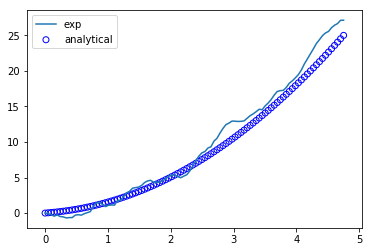

In [16]:
u_x = [xv[0] for xv in v1]

plt.plot(tseq, u_x, label = 'exp')
plt.scatter(tseq, x, facecolor = 'none', edgecolor = 'b', label='analytical')
plt.legend(loc='upper left')
plt.show()

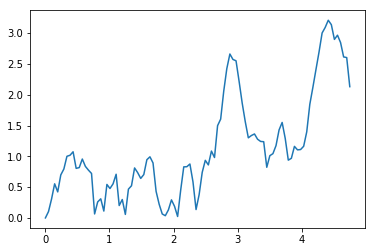

In [18]:
plt.plot(tseq, abs(x-u_x), label = 'Error')
plt.show()

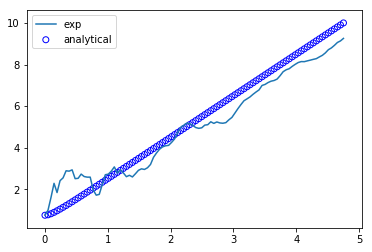

In [19]:
u_v = [xv[1] for xv in v1]

plt.plot(tseq, u_v, label = 'exp')
plt.scatter(tseq, v, facecolor = 'none', edgecolor = 'b', label='analytical')
plt.legend(loc='upper left')
plt.show()

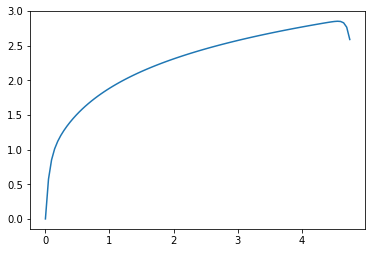

In [20]:
kf2 = KalmanFilter(initial_state_mean=[x0, f(x0, tseq[0])], initial_state_covariance=[[0,0],[0,0]], n_dim_obs=2)
mu_smooth = kf2.smooth([list(i) for i in zip(xstar,vstar)])[0]
mu_smooth = [mu[0] for mu in mu_smooth]
plt.plot(tseq, abs(np.array(mu_star)[0]-mu_smooth), label = 'Error')